# Fisher's Linear Discriminant

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

In [2]:
df = pd.read_csv('dataset_FLD.csv', names = ['feature1', 'feature2', 'feature3', 'target'])
df.head()

,feature1,feature2,feature3,target
0,-6.672418,-1.206198,-1.081050,0
1,1.675598,0.614994,-0.971600,0
2,-4.039058,0.335102,0.544618,1
3,0.793526,-0.235277,0.551771,1
4,3.820273,-0.274691,0.454743,1


In [3]:
#Dividing Dataset into 2 classes
pClass = df[df.iloc[:, -1] == 1].to_numpy()
nClass = df[df.iloc[:, -1] == 0].to_numpy()



X_p = pClass[:, :-1]
y_p = pClass[:, -1].reshape(-1, 1)

X_n = nClass[:, :-1]
y_n = nClass[:, -1].reshape(-1, 1)

In [4]:
X_p.shape, y_p.shape, X_n.shape, y_n.shape

((500, 3), (500, 1), (500, 3), (500, 1))

In [5]:
pos_df, neg_df = [features for c, features in df.groupby('target')]

X_p = pos_df.drop(['target'], axis=1).to_numpy()
X_n = neg_df.drop(['target'], axis=1).to_numpy()

dataset = df.to_numpy()

X = dataset[:, :3]
y = dataset[:, -1].reshape(-1, 1)

In [6]:
X_p.shape, X_n.shape, X.shape, y.shape

((500, 3), (500, 3), (1000, 3), (1000, 1))

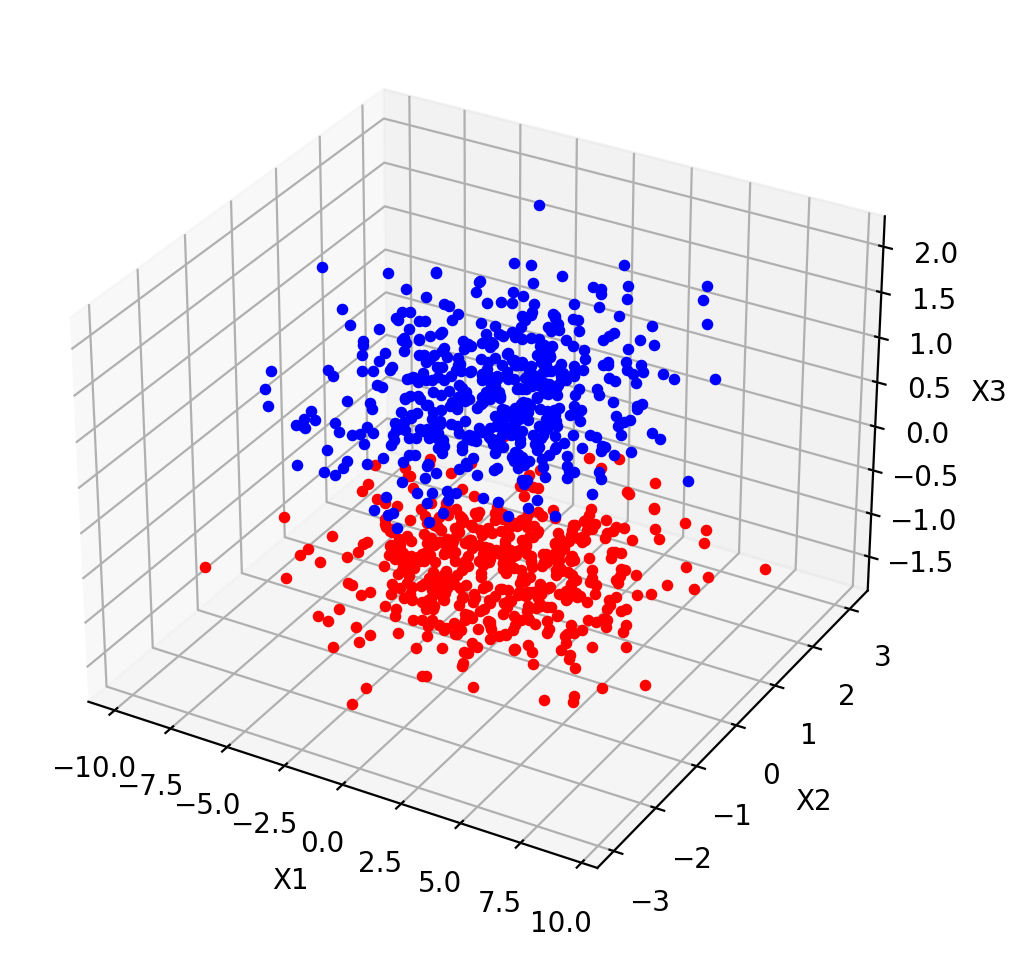

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

ax.scatter(X_p[:, 0], X_p[:, 1], X_p[:, 2], s=10, color=[1, 0, 0], depthshade=False)
ax.scatter(X_n[:, 0], X_n[:, 1], X_n[:, 2], s=10, color=[0, 0, 1], depthshade=False)

## Terms

$ \text{S}_{\text{w}} $: Total within class covariance matrix

$ \text{M}_{\text{1}} $: Mean Vector of Class 0

$ \text{M}_{\text{2}} $: Mean Vector of Class 1

$ \text{w} $: Weight Vector

$$ w \propto S_w^{-1} (M_1 - M_2) $$

In [8]:
def getW(X_p, X_n):
    M_p = np.mean(X_p, axis=0)
    M_n = np.mean(X_n, axis=0)
    
    C1 = np.cov(X_p.T)
    C2 = np.cov(X_n.T)
    
    #Total within class covariance
    Sw = C1 + C2
    Sw_in = np.linalg.inv(Sw)
    
    W = Sw_in @ (M_p - M_n)
    
    #Normalise???????
    return W

In [9]:
def getGaussianStats(X, W):
    D = np.dot(W, X.T)
    mean = np.mean(D)
    std = np.std(D)
    var = np.var(D)
    
    Z = -((X - mean) ** 2)/(2 * var)
    Y = (1 / np.sqrt( 2 * np.pi * var)) * np.exp(Z)
    
    stats = {'mean': mean, 'std': std, 'var': var, 'pdf': Y}
    return stats

## Finding intersecting point

<font size = "4">Let the Gaussian Distribution of the classes : <code>0</code> and <code>1</code></font>

<font size = "4">$y_0 = \frac{1}{\sqrt{2\pi\sigma^{2}_0}} e^{\frac{-(X - \mu_0)^2}{2\sigma_0}}$</font>
    
<font size = "4">$y_1 = \frac{1}{\sqrt{2\pi\sigma^{2}_1}} e^{\frac{-(X - \mu_1)^2}{2\sigma_1}}$</font>

On solving for the intersection point we get - 
    
<font size = "4">$(\frac{1}{\sigma_0^{2}} - \frac{1}{\sigma_1^{2}})x^2 + 2(\frac{\mu_0}{\sigma_0^{2}} - \frac{\mu_1}{\sigma_1^{2}})x + \frac{\mu_1^2}{\sigma_1^2} - \frac{\mu_0^2}{\sigma_0^2} + \log(\frac{\mu_1}{\mu_0}) = 0$ </font>


In [10]:
def getIntersectionPoint(X_p, X_n, W):
    pStats = getGaussianStats(X_p, W)
    pMean, pVar = pStats['mean'], pStats['var']
    nStats = getGaussianStats(X_n, W)
    nMean, nVar = nStats['mean'], nStats['var']
    
    a = (1 / pVar) - (1 / nVar)
    b = 2 * (pMean/pVar - nMean/nVar)
    c = (((nMean ** 2) / nVar - (pMean ** 2) / pVar) + np.log(nVar / pVar))
    
    roots = np.roots([a, b, c])
    return roots[1]


In [11]:
def predictions(X, W, threshold):
    projections = np.dot(W, X.T).reshape(-1, 1)
    
    P = (projections >= threshold).astype(int).reshape(-1, 1)
    return P

In [12]:
def accuracy(A, P):
    total = A.shape[0]
    acc = float(np.sum(A == P)) / total

    return acc
            

In [13]:
def FLD(X_p, X_n, y_p):
    W = getW(X_p, X_n)
    
    threshold = getIntersectionPoint(X_p, X_n, W)
    P = predictions(X_p, W, threshold)
    acc = accuracy(y_p, P)
    
    return acc

In [14]:
FLD(X_p, X_n, y_p)

1.0